<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/image_classification/fixed_feature_extractor_cat_vs_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# upload kaggle API key from your local machine
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shazzadraihan","key":"852204f633bb05fc928ef0439e027938"}'}

In [ ]:
# make a kaggle dir, copy the API key to it
# and make sure the file in only readable by yourself (chmod 600)
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# use API command to download the dataset
!kaggle competitions download -c dogs-vs-cats

 97% 788M/812M [00:02<00:00, 267MB/s]
100% 812M/812M [00:03<00:00, 276MB/s]


In [ ]:
# uncompress the dataset
!unzip -qq dogs-vs-cats
!unzip -qq train.zip
!unzip -qq test1.zip

In [ ]:
# import required libraries
import torch
import torchvision

import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  print("CUDA is available!")
else:
  print("CUDA is not available!")

device = torch.device("cuda") if train_on_gpu else torch.device("cpu")

CUDA is available!


In [ ]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed = 125
set_all_seeds(seed)

In [ ]:
print(len(os.listdir("/content/train")))
print(len(os.listdir("/content/test1")))

25000
12500


In [ ]:
from PIL import Image
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

In [ ]:
# import required libraries
import os, shutil, pathlib

# path to dir where original dataset was uncompressed
original_train_dir = pathlib.Path("train")

# dir of the smaller dataset
new_base_dir = pathlib.Path("cats_vs_dogs")

def make_subset(subset_name, original_dir, new_base_dir, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index) if check_image(f"/content/train/{category}.{i}.jpg")]
    for fname in fnames:
      shutil.copyfile(src = original_dir / fname, dst = dir / fname)

# make 3 subsets: trai, validation, test
make_subset("train", original_train_dir, new_base_dir, start_index=0, end_index=1000)
make_subset("valid", original_train_dir, new_base_dir, start_index=1000, end_index=1500)
make_subset("test", original_train_dir, new_base_dir, start_index=1500, end_index=2000)

In [ ]:
train_dir = os.path.join(new_base_dir, "train")
valid_dir = os.path.join(new_base_dir, "valid")
test_dir = os.path.join(new_base_dir, "test")

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# load and transform data using ImageFolder
train_data_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.Resize((244, 244)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_data_transform = transforms.Compose([
        transforms.Resize((244, 244)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=train_data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=test_data_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_data_transform)

print("Number of training images: ", len(train_data))
print("Number of validation images: ", len(valid_data))
print("Number of test images: ", len(test_data))

Number of training images:  2000
Number of validation images:  1000
Number of test images:  1000


In [ ]:
# define dataloader parameters

# number of subprocess to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

# prepare train and validation data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# image classes in the dataset
classes = train_data.classes
print(classes)
num_classes = len(classes)

['cat', 'dog']


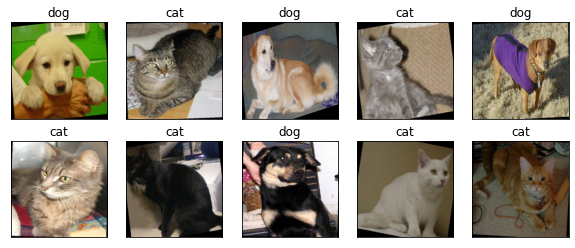

In [ ]:
# visualize a batch of training data

def imshow(img):
  # unnormalize
  img = np.transpose(img, (1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)
  plt.imshow(img)

# obtain one batch on training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# convert images to numpy for display
images = images.numpy() 

# plot the images in the batch along with the corresponding labels
fig = plt.figure(figsize=(10,4))
# display 10 images
for ind in np.arange(10):
  ax = fig.add_subplot(2, 10/2, ind+1, xticks=[], yticks=[])
  imshow(images[ind])
  ax.set_title(classes[labels[ind]])

In [ ]:
from torchvision import models

# load a pre-trained model
model = models.vgg16(pretrained=True)

# print out the model stracture
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Freeze training for all features layers, so that the network acts as a fixed feature extractor
for param in model.parameters():
  param.requires_grad = False

# fine-tune (train) the last 3 layers
# model.classifier[1].requires_grad = True
# model.classifier[3].requires_grad = True

# freeze training for all features layers, except the batchnorm layers
# for name, param in model.named_parameters():
#   if ("bn" not in name):
#     param.requires_grad = False

In [ ]:
import torch.nn as nn

# replace final classification layer with a new one
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# move model to the right device
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss() # categorical cross-entropy

# specify optimizer
params = model.parameters()
optimizer = optim.Adam(params, lr=0.0001)
# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
# number of epochs to train the model
num_epochs = 10
# track training loss
train_loss, valid_loss = [], []
# initialize tracker for min validation loss
min_valid_loss = np.inf

for epoch in range(num_epochs):
  running_train_loss = 0.0
  running_valid_loss = 0.0

  # --------- train the model -----------------
  # set model to training mode
  model.train()

  for batch_idx, data in enumerate(train_loader):
    # get the inputs, data is a list of [inputs, targets]
    inputs, targets = data
    # mode tensor to the right device
    inputs, targets = inputs.to(device), targets.to(device)
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass
    outputs = model(inputs)
    # calculate the batch loss
    loss = criterion(outputs, targets)
    # backward pass
    loss.backward()
    # update parameters
    optimizer.step()
    # update training loss
    running_train_loss += loss.item()

  # update learning rate
  lr_scheduler.step()

  # ---------- validate the model ------------
  # set the model to evaluation mode
  model.eval()

  # since we're not training, we don't need to calculate the gradients for out outputs
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(valid_loader):
      # move tensor to the right device
      inputs, targets = inputs.to(device), targets.to(device)
      # forward pass
      outputs = model(inputs)
      # calculate the batch loss
      loss = criterion(outputs, targets)
      # update validation loss
      running_valid_loss += loss.item()

  # calculate average loss over an epoch
  running_train_loss = running_train_loss / len(train_loader)
  running_valid_loss = running_valid_loss / len(valid_loader)

  train_loss.append(running_train_loss)
  valid_loss.append(running_valid_loss)

  print("Epoch: {} \tTraining loss: {:.6f} \tValidation loss: {:.6f}".format(epoch+1, running_train_loss, running_valid_loss))

  # save model if validation loss has decressed
  if running_valid_loss <= min_valid_loss:
    print("Validation loss decressed ({:.6f} --> {:.6f}). Saving model ...".format(min_valid_loss, running_valid_loss))
    torch.save(model.state_dict(), "model.pt")
    min_valid_loss = running_valid_loss

print("Finished training!")

Epoch: 1 	Training loss: 0.299046 	Validation loss: 0.135964
Validation loss decressed (inf --> 0.135964). Saving model ...
Epoch: 2 	Training loss: 0.114053 	Validation loss: 0.087487
Validation loss decressed (0.135964 --> 0.087487). Saving model ...
Epoch: 3 	Training loss: 0.085206 	Validation loss: 0.068426
Validation loss decressed (0.087487 --> 0.068426). Saving model ...
Epoch: 4 	Training loss: 0.069986 	Validation loss: 0.058236
Validation loss decressed (0.068426 --> 0.058236). Saving model ...
Epoch: 5 	Training loss: 0.057925 	Validation loss: 0.051857
Validation loss decressed (0.058236 --> 0.051857). Saving model ...
Epoch: 6 	Training loss: 0.058855 	Validation loss: 0.051345
Validation loss decressed (0.051857 --> 0.051345). Saving model ...
Epoch: 7 	Training loss: 0.054708 	Validation loss: 0.050835
Validation loss decressed (0.051345 --> 0.050835). Saving model ...
Epoch: 8 	Training loss: 0.057824 	Validation loss: 0.050333
Validation loss decressed (0.050835 --> 0

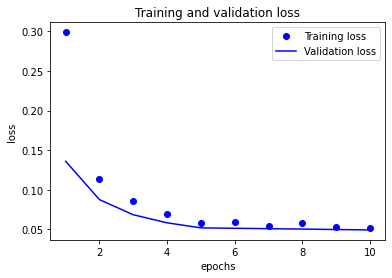

In [ ]:
# plot training and validation loss for each epoch
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, valid_loss, 'b', label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.legend(loc='upper right')
plt.show()

### Evaluate the performance of the trained model on the test dataset

In [ ]:
# load the model with the lowest validation loss
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [ ]:
# track test loss and accuracy
test_loss = 0.0
class_correct = [0 for i in range(num_classes)]
class_total = [0 for i in range(num_classes)]

model.eval()

with torch.no_grad():
  for batch_idx, (inputs, targets) in enumerate(test_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    # forward pass
    outputs = model(inputs)
    # calculate the batch loss
    loss = criterion(outputs, targets)
    # update test loss
    test_loss += loss.item()
    # convert output probabilities to predicted class
    _, predictions = torch.max(outputs, 1)
    # compare predictions to true labels
    correct_tensor = predictions.eq(targets.data.view_as(predictions))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each class
    for i in range(len(targets)):
      label = targets.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1

# average test loss
test_loss = test_loss / len(test_loader.dataset)
print("Test loss (overall): {:6f}\n".format(test_loss))

# print test accuracy for each classes
for i in range(num_classes):
  if class_total[i] > 0:
    accuracy = (100 * class_correct[i]) / class_total[i]
    print(f'Test accuracy of {classes[i]:10s}: {accuracy:.1f} % ({np.sum(class_correct[i])}/{np.sum(class_total[i])})')

# overall test accuracy
test_acc = 100 * np.sum(class_correct) / np.sum(class_total)
print("\nTest accuracy (overall): %2d%% (%2d/%2d)" % ( 
      test_acc, np.sum(class_correct), np.sum(class_total)))

Test loss (overall): 0.001367

Test accuracy of cat       : 99.2 % (496/500)
Test accuracy of dog       : 98.8 % (494/500)

Test accuracy (overall): 99% (990/1000)
